In [1]:
import pandas as pd
import yfinance as yf
import os
from dotenv import load_dotenv
import fredapi
from fredapi import Fred
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
api_key = os.getenv('FRED_API_KEY')
fred = Fred(api_key=api_key)

In [3]:
# Pull Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)
cpi = fred.get_series('CPIAUCSL', observation_start='1990-01-01')
cpi.tail()

2022-05-01    291.474
2022-06-01    295.328
2022-07-01    295.271
2022-08-01    295.620
2022-09-01    296.761
dtype: float64

<AxesSubplot:title={'center':'Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)'}, xlabel='Date', ylabel='cpi index 1982-1984 = 100'>

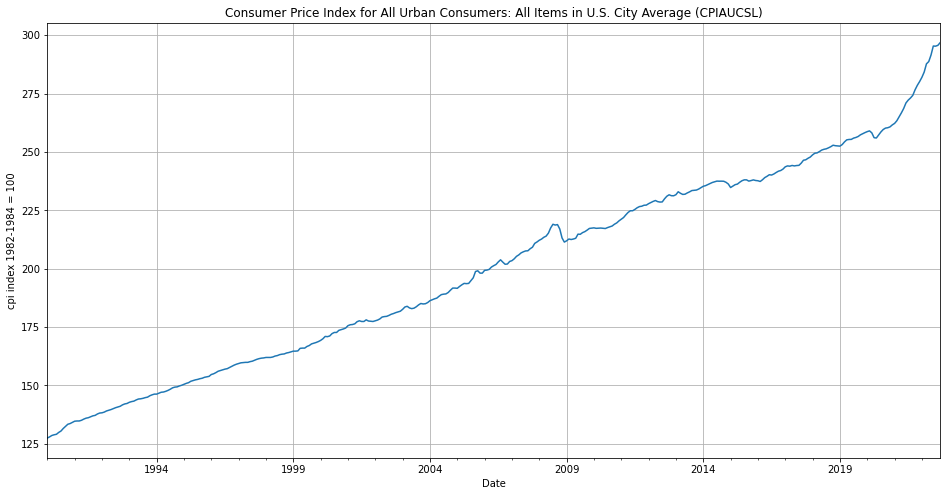

In [4]:
# Plot CPI data
cpi.plot(figsize=(16,8), title='Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)', grid=True, xlabel='Date', ylabel='cpi index 1982-1984 = 100')

In [7]:
# Pull S&P 500 historical data; set freq to monthly
ticker = "^GSPC" 
start= "1990-01-01" 
end= "2022-09-02"

sp_history = yf.download(ticker, start=start, end=end, progress=False)
sp_history = sp_history.drop(columns=(['Open', 'High','Low','Close','Volume']))
sp_history = sp_history.asfreq(freq='D').ffill().dropna()
sp_history = sp_history.rename(columns={'Adj Close':'sp_adj_close'})
sp_history.tail()

,sp_adj_close
Date,
2022-08-28,4057.659912
2022-08-29,4030.610107
2022-08-30,3986.159912
2022-08-31,3955.000000
2022-09-01,3966.850098


In [6]:
cpi_percent_change = cpi.pct_change().dropna()
cpi_percent_change.tail()

2022-05-01    0.009738
2022-06-01    0.013222
2022-07-01   -0.000193
2022-08-01    0.001182
2022-09-01    0.003860
dtype: float64

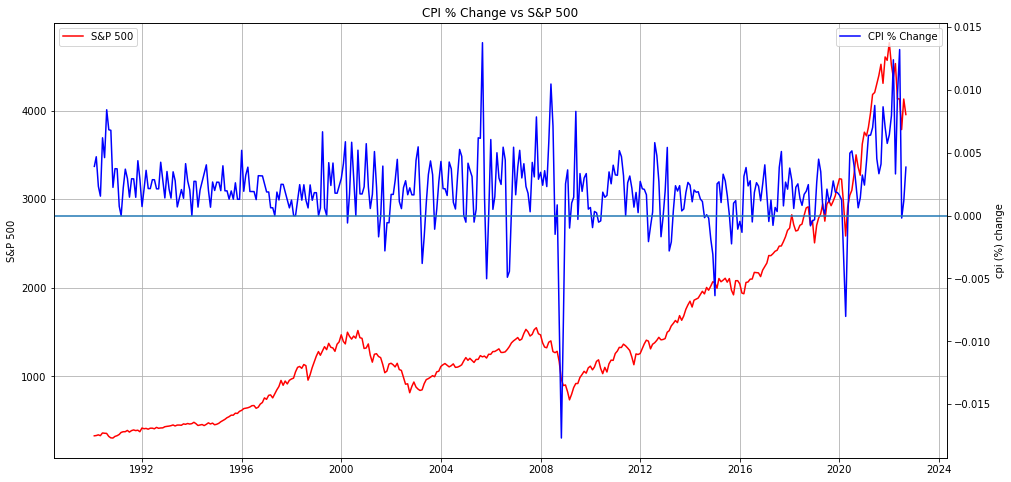

In [8]:
# Plot CPI % Change against S&P 500 index
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(sp_history['sp_adj_close'].asfreq('M').ffill().dropna(), label ='S&P 500', color='r')
ax.set_ylabel('S&P 500')
plt.grid()
ax.legend(loc='upper left')

ax2 = ax.twinx()
plt.plot(cpi_percent_change, label='CPI % Change', color='b')
ax.set_title('CPI % Change vs S&P 500')
ax2.set_ylabel('cpi (%) change')
ax2.axhline(0)
ax2.legend(loc='upper right')

In [9]:
# Concat S&P 500 and CPI data, monthly freq
combined = pd.concat([sp_history, cpi, cpi_percent_change], axis=1).dropna()
combined['CPI'] = combined[0]
combined['CPI_pct_chg'] = combined[1]
combined = combined.drop([combined.columns[1], combined.columns[2]],axis=1)
combined = combined['2021-01-01':].round(3)

In [10]:
# Set reference basket cost for comparison
ref_basket_cost = cpi['2021-01-01'] 
ref_basket_cost

262.2

In [11]:
# Adjust S&P 500 for inflation
combined['sp_inf_adj'] = (combined['sp_adj_close'] / combined['CPI']) * ref_basket_cost
combined.tail()

,sp_adj_close,CPI,CPI_pct_chg,sp_inf_adj
2022-05-01,4131.93,291.474,0.010,3716.942321
2022-06-01,4101.23,295.328,0.013,3641.180335
2022-07-01,3825.33,295.271,-0.000,3396.884645
2022-08-01,4118.63,295.620,0.001,3653.016663
2022-09-01,3966.85,296.761,0.004,3504.867789


<AxesSubplot:title={'center':'S&P 500 Inflation Adjusted - period 01-01-2018 - 12-01-2021 (reference CPI 01-01-2018)'}, xlabel='Date', ylabel='S&P 500'>

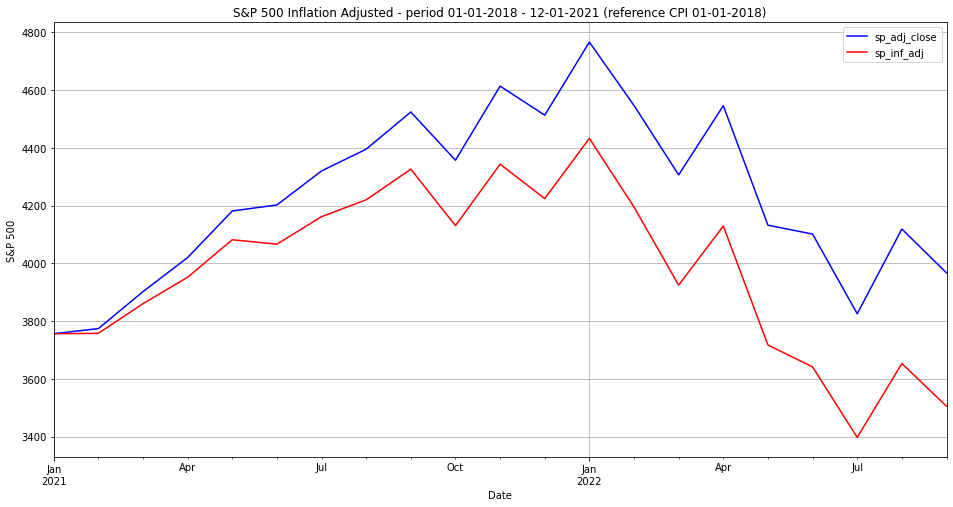

In [12]:
# Plot increase in price of reference basket for the specified time period
combined[['sp_adj_close', 'sp_inf_adj']].plot(figsize=(16,8), title='S&P 500 Inflation Adjusted - period 01-01-2018 - 12-01-2021 (reference CPI 01-01-2018)', grid=True, ylabel='S&P 500', xlabel='Date',color=('b','r'))